# Multicollinearity

This example notebook pulls a data file from the UCI machine learning database to explore multicollinearity; it's well suited because there are a lot of highly correlated variables present. 

For modeling approaches that make assumptions on relationships between features, one must be careful about variables that have high covariance. In general, when regressing, it is assumed that all of the input variables are indpendent. If two input variables have the same effect on the dependent variable, the meaning that can be assigned to that input variable as an influence on the output target is reduced. 

Some modelling approaches are sensitive to multicollinearity, such as least squares regressions. 

### Disclaimers
* This isn't intended to be comprehensive, and there are multiple ways to address multicollinearity, this notebook just highlights a couple.

* There are also lot of subtleties to this particular data, namely the ethical and legal concerns about using demographic data to make financial decisions and ultimately descriminate. For more information, please see the US Government Consumer Financial Protection Bureau's website:     
https://www.consumerfinance.gov/fair-lending/  

In [1]:
# Python library imports
from matplotlib import pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Settings
sns.set_theme('poster')

In [3]:
# Variables
fn_credit = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls'

In [4]:
# Load the data
df_credit_raw = pd.read_excel(fn_credit,
                              index_col=0,
                              header=1)

# Isolate inputs
df_credit_input = df_credit_raw.drop(columns=['default payment next month'])

## Correlation Matrix

To explore multicollinearity, first we check the correlation matrix to understand how each input variable varies with one another.

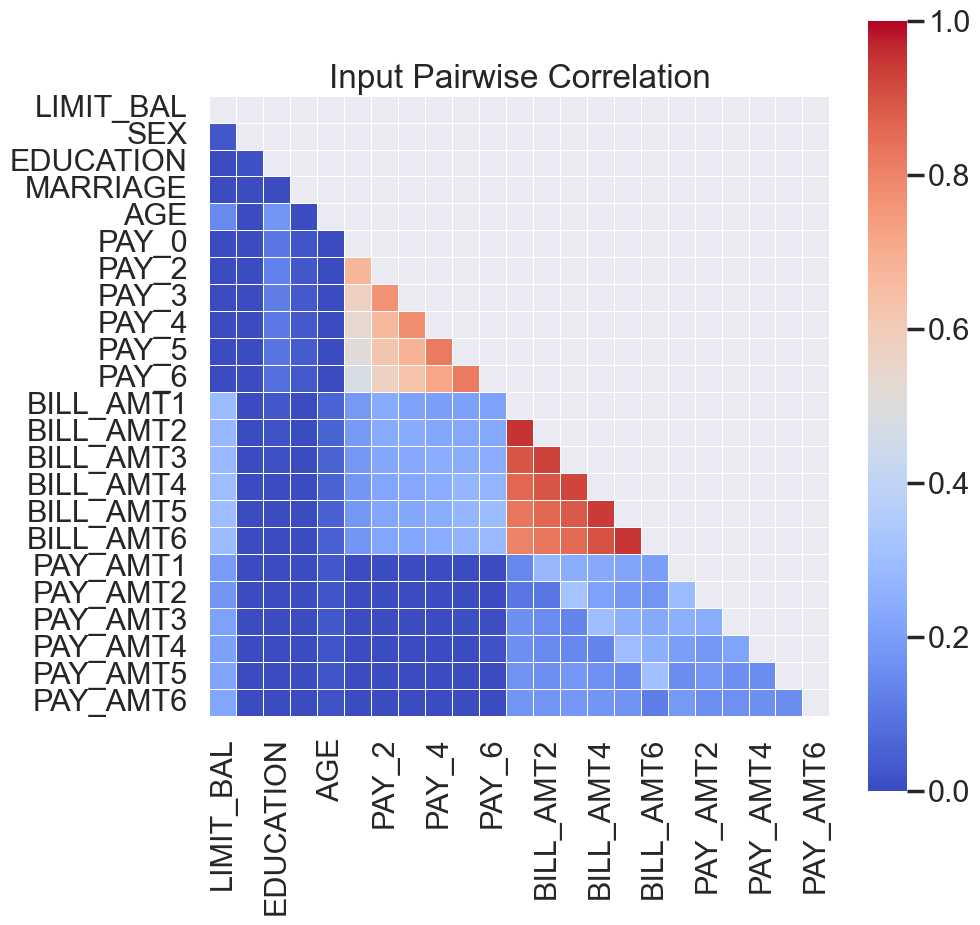

In [5]:
# Set and compute the Correlation Matrix to see which pairwise combinations are highly correlated:
corr = df_credit_input.corr() 

# Generate a mask for the upper triangle:
mask = np.zeros_like(corr, dtype='bool')  
mask[np.triu_indices_from(mask)]=True

# Set up the matplotlib figure and a diverging colormap:
f, ax = plt.subplots(figsize=(10, 10))  

# Draw the heatmap with the mask and correct aspect ratio:
sns.heatmap(corr, 
            mask=mask, 
            cmap="coolwarm",
            square=True,
            linewidths=.5,
            vmin=0, 
            vmax=1)
plt.title('Input Pairwise Correlation')
plt.show()

The `BILL_AMT`s are highly correlated (i.e. dark red), likely because charges are carried over from one bill to the next in some cases.

Let's quantify via the variance inflation factor (VIF) to determine the ratio of overall model variance to the variance of a model that includes only that single independent variable.


### Variance Inflation Factor (VIF)
While we can observe the correlations being high for some pairs of variables, a better measure of the multicollinearity is the variance inflation factor (VIF). The VIF is the ratio of the variance of a model that includes all other input variables to the variance of fitting a single, specific input variable. 

This can be calculated by ignoring the target variable Y, and regressing all the other input variables against a single variable. The VIF for that input variable is the reciprocal of one minus this input-only coefficient of determination.

The lowest possible value of 1 indicates the complete abscence of collinearity. Due to the ratiometric nature of this metric, there is thoretically no upper bound;  practically speaking values in 100's are not impossible.

In this case, a threshold (e.g. 5 or 10) is used to identify collinear variables. Once identified, there are multiple ways of addressing the highly collinear variables: 
* One is to **drop the highly collinear variables** and recalculate the VIF to see if the subsequent VIF values have dropped.  

* The other option is to **combine collinear variables in such a way that a new, single variable is produced**. This could be accomplished through some form of variable reduction, but should always consider the relationship between the problem at hand, target variable, and input information. This is currently out to scope for this notebook. 

By addressing variables with a high VIF, it becomes far more straightforward interpret the relative significance of the fits more clearly because the input variables are more independent.

In [6]:
# VIF function wrapper using Pandas
def calc_vif(df:pd.DataFrame):
    '''
    Determine the variation inflaction factor for all columns in a dataframe.
    
    VIF calculation assumes a constant, so one is added as part of a wrapper function.
    https://github.com/statsmodels/statsmodels/issues/2376
    '''
    df_c = df.assign(const=1)
    vif = pd.Series([variance_inflation_factor(df_c.values, i) 
                                    for i in range(df_c.shape[1])],
                       index=df_c.columns)
    vif.drop(index=['const'], inplace=True)
    return(vif)

In [7]:
# Calculate variance inflation factor  
calc_vif(df_credit_input)

LIMIT_BAL     1.558496
SEX           1.024003
EDUCATION     1.125883
MARRIAGE      1.230199
AGE           1.275122
PAY_0         1.919757
PAY_2         3.173306
PAY_3         3.657496
PAY_4         4.287408
PAY_5         4.725098
PAY_6         3.256188
BILL_AMT1    14.032744
BILL_AMT2    25.864853
BILL_AMT3    21.775684
BILL_AMT4    20.346841
BILL_AMT5    24.996689
BILL_AMT6    15.024784
PAY_AMT1      1.707850
PAY_AMT2      2.237123
PAY_AMT3      1.757028
PAY_AMT4      1.648692
PAY_AMT5      1.687730
PAY_AMT6      1.169971
dtype: float64

In [8]:
# Sequentially select columns to remove via high VIF values:
vif_threshold = 5

mc_cols = []
curr_vif = calc_vif(df_credit_input.drop(columns=mc_cols))
while curr_vif.max() > vif_threshold:
    curr_mc_col = curr_vif.idxmax()
    
    print(f"Appending {curr_mc_col} to list of highly multicollinear columns and rechecking VIF...")
    mc_cols.append(curr_mc_col)
    
    curr_vif = calc_vif(df_credit_input.drop(columns=mc_cols))
    
# Drop columns with VIF > vif_threshold   
calc_vif(df_credit_input.drop(columns=mc_cols))

Appending BILL_AMT2 to list of highly multicollinear columns and rechecking VIF...
Appending BILL_AMT5 to list of highly multicollinear columns and rechecking VIF...
Appending BILL_AMT3 to list of highly multicollinear columns and rechecking VIF...
Appending BILL_AMT4 to list of highly multicollinear columns and rechecking VIF...


LIMIT_BAL    1.552928
SEX          1.023784
EDUCATION    1.125588
MARRIAGE     1.230016
AGE          1.275056
PAY_0        1.919207
PAY_2        3.168519
PAY_3        3.635258
PAY_4        4.274782
PAY_5        4.704730
PAY_6        3.247593
BILL_AMT1    3.131387
BILL_AMT6    3.593371
PAY_AMT1     1.206116
PAY_AMT2     1.184269
PAY_AMT3     1.203640
PAY_AMT4     1.172402
PAY_AMT5     1.202260
PAY_AMT6     1.138352
dtype: float64

Note that the VIF values for `BILL_AMT1` and `BILL_AMT6` have dropped significantly.

It's not surprising, but a review of the correlation matrix is always a good sanity check:

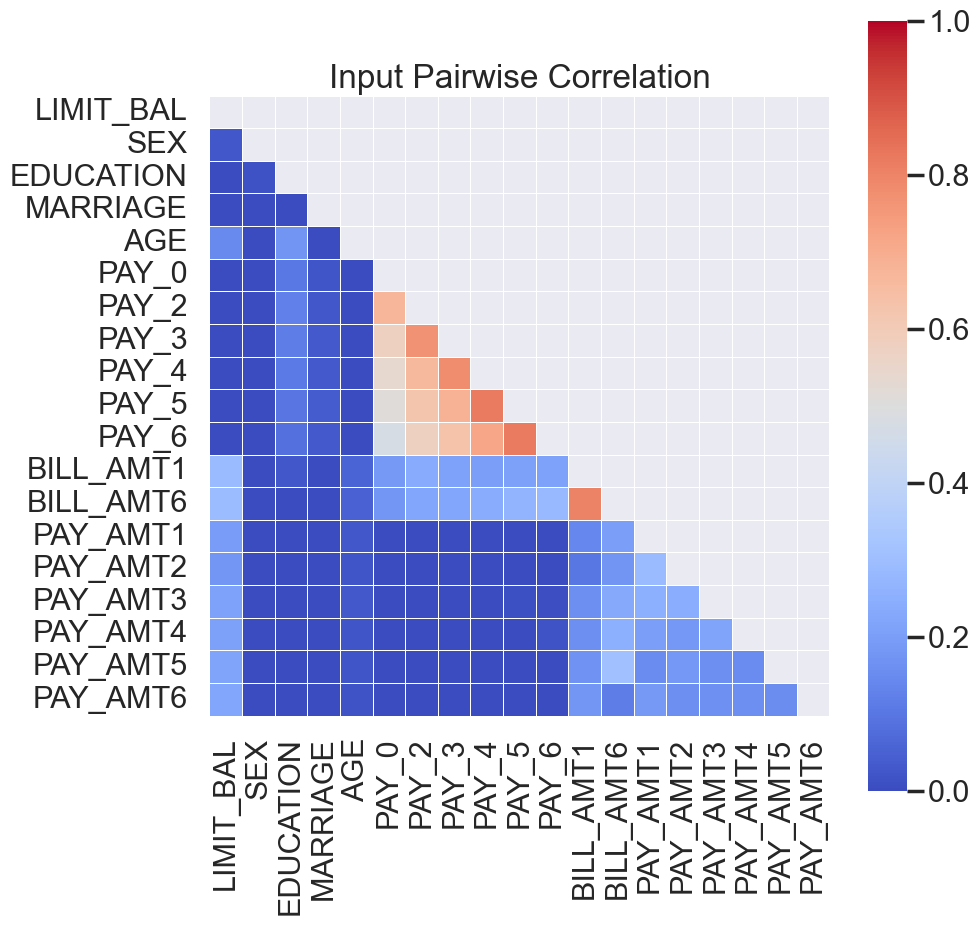

In [9]:
# Set and compute the Correlation Matrix to see which pairwise combinations are highly correlated:
corr = df_credit_input.drop(columns=mc_cols).corr() 

# Generate a mask for the upper triangle:
mask = np.zeros_like(corr, dtype='bool')  
mask[np.triu_indices_from(mask)]=True

# Set up the matplotlib figure and a diverging colormap:
f, ax = plt.subplots(figsize=(10, 10))  

# Draw the heatmap with the mask and correct aspect ratio:
sns.heatmap(corr, 
            mask=mask, 
            cmap="coolwarm",
            square=True,
            linewidths=.5,
            vmin=0, 
            vmax=1)
plt.title('Input Pairwise Correlation')
plt.show()

References:
    
James, Gareth; Witten, Daniela; Hastie, Trevor; Tibshirani, Robert (2021). An Introduction to Statistical Learning (2nd ed.). Springer Texts in Statistics.